In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import stats
from google.cloud import bigquery
from google.oauth2 import service_account
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.style.use('ggplot')
from matplotlib.lines import Line2D


In [674]:
# os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Config')
# credentials = service_account.Credentials.from_service_account_file('bigqueryauth.json')
# project_id = 'solar-222307'
# client = bigquery.Client(credentials= credentials,project=project_id)
# query_job = client.query('select * from loggers.tuya')
# tuya_data = query_job.result().to_dataframe() 
# os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
# tuya_data.to_pickle("Tuya_Data.pkl")

### Get Data

In [6]:
os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
old_data=pd.read_pickle("Tuya_Data.pkl")
old_data['event_time_utc']=pd.to_datetime(old_data['event_time_utc'])
last_timestamp=old_data.sort_values('event_time_utc')['event_time_utc'].iloc[-1]

os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Config')
credentials = service_account.Credentials.from_service_account_file('bigqueryauth.json')
project_id = 'solar-222307'
client = bigquery.Client(credentials= credentials,project=project_id)

query_job=client.query('select * from loggers.tuya where event_time_utc>"{}"'.format(last_timestamp))
# query_job=client.query('select * from loggers.tuya')
tuya_data = query_job.result().to_dataframe() 

os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
if len(tuya_data)>0:
    tuya_data['value']=tuya_data['value'].replace('true','1').replace('false','0')
    tuya_data['value']=tuya_data['value'].astype(float)
    tuya_data['event_time_utc']=pd.to_datetime(tuya_data['event_time_utc'])
    tuya_data=tuya_data.drop_duplicates(subset=['device_id','event_timestamp','code','value'])


    pivot_data=tuya_data.pivot_table(index=['property_id','device_id','event_time_utc'], columns='code', values='value')
    pivot_data=pivot_data.reset_index()
    pivot_data['Date']=[i.date() for i in pivot_data['event_time_utc']]

    for i,j in pivot_data[['device_id','property_id']].drop_duplicates().itertuples(index=False):
        pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_voltage']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_voltage'].fillna(method='ffill')
        pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_power']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_power'].fillna(method='ffill')
        pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_current']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_current'].fillna(method='ffill')


    pivot_data['Month'] = [i.month for i in pivot_data['event_time_utc']]
    pivot_data['Week'] = [i.week for i in pivot_data['event_time_utc']]
    pivot_data['Year'] = [i.year for i in pivot_data['event_time_utc']]

    pivot_data=pivot_data.append(old_data)
    pivot_data.to_pickle("Tuya_Data.pkl")

os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
pivot_data=pd.read_pickle("Tuya_Data.pkl")
pivot_data['event_time_utc']=pd.to_datetime(pivot_data['event_time_utc']) +datetime.timedelta(hours=5.5)

onset_data=pd.read_pickle('onset_data.pkl')
onset_data['logged_time_local']=pd.to_datetime(onset_data['logged_time_local'])
last_timestamp=onset_data.sort_values('logged_time_local')['logged_time_local'].iloc[-1]

query_job=client.query('select * from loggers.onset where logged_time_local>"{}"'.format(last_timestamp))
results = query_job.result().to_dataframe() # Wait for the job to complete.
onset_data=onset_data.append(results)
onset_data.to_pickle('onset_data.pkl')
onset_data['logged_time_local']=pd.to_datetime(onset_data['logged_time_local'])
pivot_data=pivot_data.reset_index()
onset_data=onset_data.reset_index()


In [7]:
onset_data['logged_time_local'].max()

Timestamp('2021-02-15 13:15:17')

In [19]:
device_map=pd.read_excel('Tuya devices power.xlsx').fillna('none')
device_map1=device_map[['tuya_id','equipment_name']].set_index('tuya_id').to_dict()['equipment_name']
device_map2=device_map[['tuya_id','mean_power_consumption']].set_index('tuya_id').to_dict()['mean_power_consumption']
device_map3=device_map[['tuya_id','consumption_category']].set_index('tuya_id').to_dict()['consumption_category']
pivot_data['equipment_name']=pivot_data['device_id'].map(device_map1)
pivot_data['device_mean_consumption']=pivot_data['device_id'].map(device_map2)
pivot_data['consumption_category']=pivot_data['device_id'].map(device_map3)

In [20]:
device_map

,tuya_id,Property_id,name,equipment_name,phase,room,mean_power_consumption,consumption_category
0,bf77c5e5790a5ca71a3vjf,15,wipro 4,Microwave,Green,kitchen,0.110,medium
1,bf9882ef90bc93335en4ah,15,wipro 5,AC1,Red,gf bedroom 3,0.200,medium
2,bf328a81d14dcceb63w5pc,15,wipro 6,Geyser2,1,Washroom-1,2.150,high
3,71620877500291049610,15,smart plug-10A 3,Exhaust Fan1,1,Washroom - 1,0.017,low
4,71620877500291089a0b,15,smart plug-10A 5,Exhaust Fan2,1,Washroom - 2,0.020,low
5,716208775002910494dd,15,smart plug-10A 9,Mobile Charge2,Green,GF Bedroom -2,0.034,low
6,7162087750029107ee30,15,smart plug-10A 11,Exhaust Fan3,Green,GF Washrom-3,0.018,low
7,7162087750029104969a,15,smart plug-10A 12,Router1,Blue,Ground Floor Living Room,0.003,low
8,7162087750029102561e,15,smart plug-10A 14,R.O1,Green,Kitchen,0.042,low
9,32750035500291025a61,15,smart plug-16A,Geyser1,Green,GF Washrom-3,2.015,high


In [21]:
# for i in pivot_data['equipment_name'].unique():
mask=(pivot_data['event_time_utc']>pd.to_datetime('2021-01-04')) & (pivot_data['event_time_utc']<pd.to_datetime('2021-01-16'))
pivot_data[mask & (pivot_data['equipment_name']=='Washing Machine') & (pivot_data['cur_power']>0)].dropna(subset=['cur_power'])['cur_power'].quantile([.05,.25,.5,.75,.9,.98])
# pivot_data[mask & (pivot_data['equipment_name']=='Lights1') & (pivot_data['cur_power']>0)].dropna(subset=['cur_power']).sort_values('cur_power')[-30:]

0.05     72.00
0.25     95.00
0.50    128.00
0.75    209.00
0.90    384.00
0.98    755.92
Name: cur_power, dtype: float64

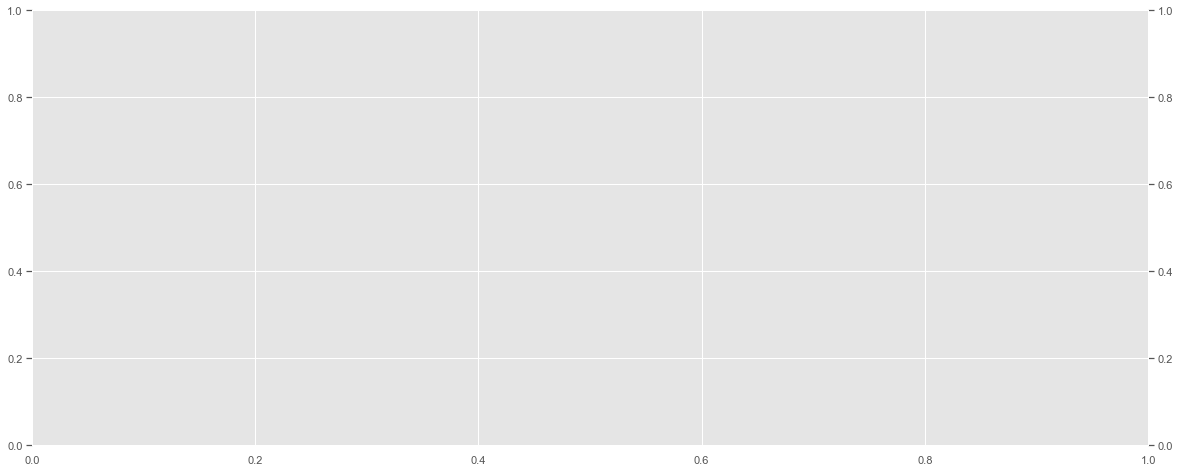

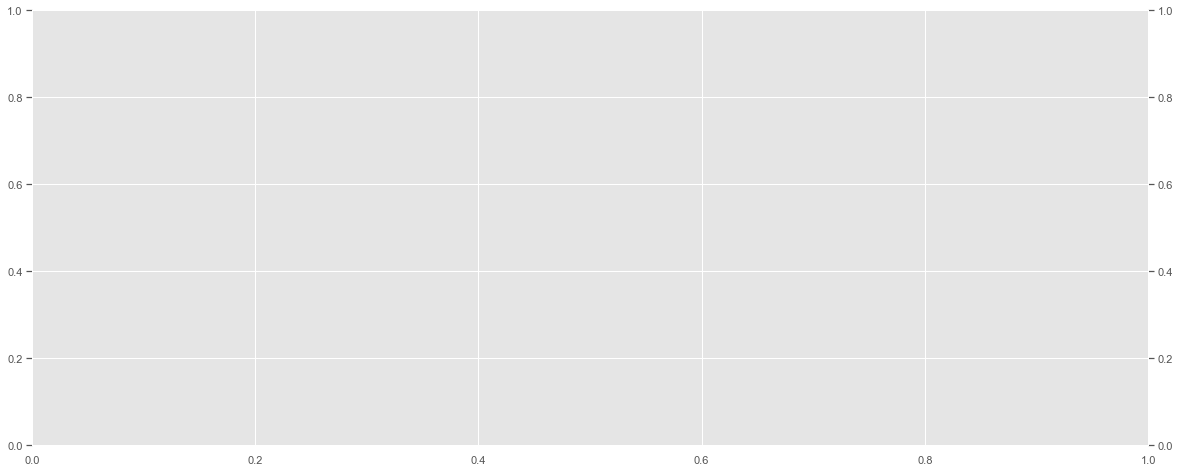

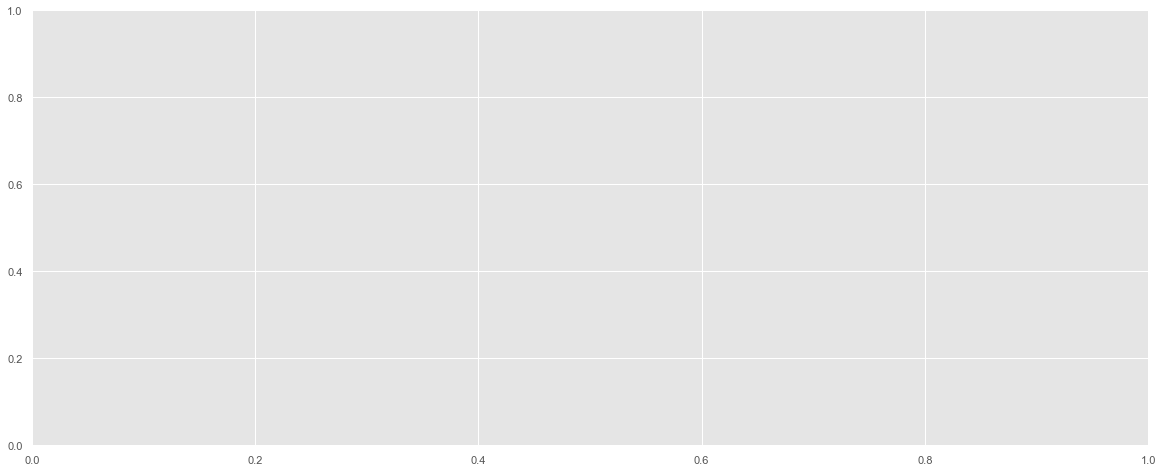

In [22]:
pivot_data=pivot_data.sort_values('event_time_utc')
onset_data=onset_data.sort_values('logged_time_local')
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

dropdown_feature = widgets.Dropdown(options = ['ALL','cur_current','cur_power', 'cur_voltage'],description = 'Tuya Feature')
dropdown_deviceid = widgets.Dropdown(options = unique_sorted_values_plus_ALL(pivot_data['equipment_name'].astype(str)), description='Device')
dropdown_time = widgets.Dropdown()
dropdown_time_window= widgets.Dropdown(options = ['30','100','300','1000', '3000','10000','30000','100000'],description = 'Seconds Window')
dropdown_feature_onset = widgets.Dropdown(options = ['mains_power','ct1_amperage', 'ct2_amperage','ct3_amperage'],description = 'Onset Feature')
dropdown_start_day = widgets.Text(description='Start Time')
dropdown_end_day = widgets.Text(description='End Time')

output=widgets.Output()
plot_output=widgets.Output()
tuya_onset=widgets.Output()
close_up=widgets.Output()
tuya_onset_all_devices=widgets.Output()
close_up_all_devices=widgets.Output()

input_widgets = widgets.HBox([dropdown_deviceid, dropdown_feature,dropdown_time,dropdown_time_window,dropdown_feature_onset,dropdown_start_day,dropdown_end_day],
                             layout=widgets.Layout(width='100%',display='inline-flex',flex_flow='row wrap'))
tab = widgets.Tab([output, plot_output, tuya_onset,close_up,tuya_onset_all_devices,close_up_all_devices])
tab.set_title(0, 'Dataset Exploration')
tab.set_title(1, 'Scatter Plot')
tab.set_title(2, 'Tuya+Onset')
tab.set_title(3, 'Close Up')
tab.set_title(4, 'All Devices')
tab.set_title(5, 'Close Up All Devices')

# @interact(device = dropdown_deviceid, feature = dropdown_feature,time = dropdown_time,window=dropdown_time_window)
def common_filtering(time,device, feature,window,onset_feature,day1,day2):
    
    output.clear_output()
    plot_output.clear_output()
    tuya_onset.clear_output()
    close_up.clear_output()
    tuya_onset_all_devices.clear_output()
    close_up_all_devices.clear_output()
    if (device != ALL):
            
        common_filter = pivot_data[(pivot_data.equipment_name == device)]


        dropdown_time.options = common_filter.set_index('event_time_utc').sort_index().switch_1.dropna().index.unique().tolist()
        dropdown_time.description='Time'
        with output:
            display(common_filter)
        with plot_output:
            fig,ax = plt.subplots()
            fig.set_size_inches(20,8)
            ax2 = ax.twinx()

            mask=(pd.to_datetime(common_filter['event_time_utc'])>pd.to_datetime(time)-datetime.timedelta(seconds=int(window))) & (pd.to_datetime(common_filter['event_time_utc'])<pd.to_datetime(time)+datetime.timedelta(seconds=int(window)))
            if feature == ALL:
                ax.plot(common_filter[mask]['event_time_utc'],common_filter[mask][['cur_current','cur_power', 'cur_voltage']], lw=0, ms=2, marker='o')
            else:
                ax.plot(common_filter[mask]['event_time_utc'],common_filter[mask][feature], 'g', lw=1, ms=2, marker='o')
            ax2.plot(common_filter[mask]['event_time_utc'],common_filter[mask]['countdown_1'], 'b', lw=0, ms=2, marker='o')
            ax2.plot(common_filter[mask]['event_time_utc'],common_filter[mask]['switch_1'], 'y', lw=0, ms=4, marker='o')

            ax.set_ylabel(feature, color='g')
            ax.set_xlabel('Event Time')
            ax.grid('')
            ax2.grid('')
            ax2.set_ylabel('Countdown(blue) and Switch(yellow)', color='b')
            plt.show()
        with tuya_onset:

            fig,ax = plt.subplots()
            fig.set_size_inches(20,8)
            ax2 = ax.twinx()            
            mask=(pd.to_datetime(onset_data['logged_time_local'])>pd.to_datetime(time)-datetime.timedelta(seconds=int(window))) & (pd.to_datetime(onset_data['logged_time_local'])<pd.to_datetime(time)+datetime.timedelta(seconds=int(window)))
            temp=onset_data[mask].sort_values('logged_time_local')
            ax.plot(temp.logged_time_local,temp[onset_feature],color='black')
            mask=(pd.to_datetime(common_filter['event_time_utc'])>pd.to_datetime(time)-datetime.timedelta(seconds=int(window))) & (pd.to_datetime(common_filter['event_time_utc'])<pd.to_datetime(time)+datetime.timedelta(seconds=int(window)))
            ax.plot(common_filter[mask]['event_time_utc'],common_filter[mask]['cur_power']/10000, 'g', lw=1, ms=2, marker='o')
            if int(common_filter.set_index('event_time_utc').loc[time,'switch_1'])==1: 
                colour='green' 
            else: 
                colour= 'red'
            plt.axvline(pd.to_datetime(time), color=colour, lw=.2)
            ax.grid('')
            ax2.grid('')
            plt.show()
            
        with tuya_onset_all_devices:

            fig,ax = plt.subplots()
            fig.set_size_inches(20,8)          
            mask=(pd.to_datetime(onset_data['logged_time_local'])>pd.to_datetime(time)-datetime.timedelta(seconds=int(window))) & (pd.to_datetime(onset_data['logged_time_local'])<pd.to_datetime(time)+datetime.timedelta(seconds=int(window)))
            temp=onset_data[mask].sort_values('logged_time_local')
            ax.plot(temp.logged_time_local,temp[onset_feature],color='black')
            mask=(pd.to_datetime(pivot_data['event_time_utc'])>pd.to_datetime(time)-datetime.timedelta(seconds=int(window))) & (pd.to_datetime(pivot_data['event_time_utc'])<pd.to_datetime(time)+datetime.timedelta(seconds=int(window)))
            for i,j in zip(pivot_data['equipment_name'].unique(),range(len(pivot_data['equipment_name'].unique()))):
                ax.plot(pivot_data[mask & (pivot_data['equipment_name']==i) & (pivot_data['cur_power']>0)]['event_time_utc'],pivot_data[mask & (pivot_data['equipment_name']==i) & (pivot_data['cur_power']>0)]['cur_power']/10000, lw=1.5, ms=6, marker=list(Line2D.markers.keys())[j],label=i)
            ax.legend(loc=(1,0))
            ax.grid('')
            plt.show()
            if day1 and day2:
                
                with close_up:
                    fig,ax = plt.subplots()
                    fig.set_size_inches(20,8)
#                     ax2 = ax.twinx()            
                    mask=(pd.to_datetime(onset_data['logged_time_local'])>pd.to_datetime(day1)) & (pd.to_datetime(onset_data['logged_time_local'])<pd.to_datetime(day2))
                    temp=onset_data[mask].sort_values('logged_time_local')
                    ax.plot(temp.logged_time_local,temp[onset_feature],color='black')
                    mask=(pd.to_datetime(common_filter['event_time_utc'])>pd.to_datetime(day1)) & (pd.to_datetime(common_filter['event_time_utc'])<pd.to_datetime(day2))
                    ax.plot(common_filter[mask]['event_time_utc'],common_filter[mask]['cur_power']/10000, 'g', lw=1, ms=2, marker='o')
                    if int(common_filter.set_index('event_time_utc').loc[time,'switch_1'])==1: 
                        colour='green' 
                    else: 
                        colour= 'red'
#                     plt.axvline(pd.to_datetime(time), color=colour, lw=.2)
                    ax.grid('')
#                     ax2.grid('')
                    plt.show()
            
                with close_up_all_devices:
                    fig,ax = plt.subplots()
                    fig.set_size_inches(20,8)
#                     ax2 = ax.twinx()            
                    mask=(pd.to_datetime(onset_data['logged_time_local'])>pd.to_datetime(day1)) & (pd.to_datetime(onset_data['logged_time_local'])<pd.to_datetime(day2))
                    temp=onset_data[mask].sort_values('logged_time_local')
                    ax.plot(temp.logged_time_local,temp[onset_feature],color='black')
                    mask=(pd.to_datetime(pivot_data['event_time_utc'])>pd.to_datetime(day1)) & (pd.to_datetime(pivot_data['event_time_utc'])<pd.to_datetime(day2))
                    for i,j in zip(pivot_data['equipment_name'].unique(),range(len(pivot_data['equipment_name'].unique()))):
                        ax.plot(pivot_data[mask & (pivot_data['equipment_name']==i) & (pivot_data['cur_power']>0)]['event_time_utc'],pivot_data[mask & (pivot_data['equipment_name']==i) & (pivot_data['cur_power']>0)]['cur_power']/10000, lw=1.5, ms=6, marker=list(Line2D.markers.keys())[j],label=i)
                    if int(common_filter.set_index('event_time_utc').loc[time,'switch_1'])==1: 
                        colour='green' 
                    else: 
                        colour= 'red'
#                     plt.axvline(pd.to_datetime(time), color=colour, lw=.2)
                    ax.grid('')
#                     ax2.grid('')
                    ax.legend(loc=(1,0))
                    plt.show()
                    

def dropdown_device_eventhandler(change):
    common_filtering(dropdown_time.value,change.new,dropdown_feature.value,dropdown_time_window.value,dropdown_feature_onset.value,
                    dropdown_start_day.value,dropdown_end_day.value)
def dropdown_feature_eventhandler(change):
    common_filtering(dropdown_time.value,dropdown_deviceid.value, change.new,dropdown_time_window.value,dropdown_feature_onset.value,dropdown_start_day.value,dropdown_end_day.value)
def dropdown_time_eventhandler(change):
    common_filtering(change.new, dropdown_deviceid.value,
                     dropdown_feature.value,dropdown_time_window.value,dropdown_feature_onset.value,dropdown_start_day.value,dropdown_end_day.value)
def dropdown_time_window_eventhandler(change):
    common_filtering(dropdown_time.value, dropdown_deviceid.value,
                 dropdown_feature.value,change.new,dropdown_feature_onset.value,dropdown_start_day.value,dropdown_end_day.value)
def dropdown_feature_onset_eventhandler(change):
    common_filtering(dropdown_time.value, dropdown_deviceid.value,
                 dropdown_feature.value,dropdown_time_window.value,change.new,dropdown_start_day.value,dropdown_end_day.value)
def dropdown_start_day_eventhandler(change):
    common_filtering(dropdown_time.value,dropdown_deviceid.value,dropdown_feature.value,dropdown_time_window.value,dropdown_feature_onset.value,
                    change.new,dropdown_end_day.value)
def dropdown_end_day_eventhandler(change):
    common_filtering(dropdown_time.value,dropdown_deviceid.value,dropdown_feature.value,dropdown_time_window.value,dropdown_feature_onset.value,
                    dropdown_start_day.value,change.new)
    

    
dropdown_deviceid.observe(dropdown_device_eventhandler, names='value')
dropdown_time.observe(dropdown_time_eventhandler, names='value')
dropdown_feature.observe(dropdown_feature_eventhandler, names='value')
dropdown_time_window.observe(dropdown_time_window_eventhandler, names='value')
dropdown_feature_onset.observe(dropdown_feature_onset_eventhandler, names='value')
dropdown_start_day.observe(dropdown_start_day_eventhandler, names='value')
dropdown_end_day.observe(dropdown_end_day_eventhandler, names='value')

display(input_widgets)
display(tab)

In [247]:
stdate='2021-01-04 00:00:00'
enddate='2021-01-05 00:00:00'
sample_data=onset_data[(onset_data['logged_time_local']>=pd.to_datetime(stdate)) & (onset_data['logged_time_local']<=pd.to_datetime(enddate))][['mains_power','logged_time_local']].sort_values('logged_time_local')

mean_step=2
factor=10

### Processing
sample_data['before_mean']=sample_data['mains_power'].rolling(mean_step).mean()
sample_data['before_max_10']=sample_data['mains_power'].abs().rolling(mean_step*factor).max()
sample_data['before_mean_10']=sample_data['mains_power'].abs().rolling(mean_step*factor).mean()
sample_data['after_mean']=0
sample_data['after_mean_10']=0
sample_data['after_max_10']=0
sample_data['per_change']=0
sample_data['time_spent']=0

# Features
per_change=[]
after_mean=[]
after_mean_10=[]
after_max=[]
# events=[]
for i in range(mean_step,len(sample_data)-mean_step):
    change=100*(sample_data['before_mean'].iloc[i+mean_step]-sample_data['before_mean'].iloc[i-1])/sample_data['before_mean'].iloc[i+mean_step]
    per_change.append(change)
    after_mean.append(sample_data['before_mean'].iloc[i+mean_step])

for i in range(mean_step*factor,len(sample_data)-mean_step*factor-3):
    after_mean_10.append(sample_data['before_mean_10'].iloc[i+3+mean_step*factor])
    after_max.append(sample_data['before_max_10'].iloc[i+3+mean_step*factor])
#     if abs(change)>5:
#         events.append(sample_data['mains_power'].iloc[i])
#     else:
#         events.append(0)
        
sample_data['per_change'].iloc[mean_step:-mean_step]=per_change
sample_data['after_mean'].iloc[mean_step:-mean_step]=after_mean
sample_data['after_mean_10'].iloc[mean_step*factor:-mean_step*factor-3]=after_mean_10
sample_data['after_max_10'].iloc[mean_step*factor:-mean_step*factor-3]=after_max
sample_data['avg_diff']=sample_data['after_mean']-sample_data['before_mean']
sample_data['avg_diff']=sample_data['after_mean']-sample_data['before_mean']

sample_data['events']=0
# sample_data.loc[(abs(sample_data['avg_diff'])>.01), 'events']=1
sample_data.loc[(abs(sample_data['avg_diff'])>.015) & (sample_data['mains_power']<.10), 'events']=1
sample_data.loc[(abs(sample_data['per_change'])>10) & (sample_data['mains_power']>.10), 'events']=1
sample_data=sample_data
sample_data['event_type']=0

#### transition start=1, transition= 2, transition end=3, steady=0
sample_data.loc[sample_data['events']==True,'event_type']=2
sample_data.loc[sample_data['events']==False,'event_type']=0

sample_data['event_effect']=0
prev_state=0
event_mean_before=0
for i in range(len(sample_data)):
    if sample_data['events'].iloc[i]==0:
        if prev_state==1:
            sample_data['event_type'].iloc[i]=3
        prev_state=0
    else:
        if prev_state==0:
            sample_data['event_type'].iloc[i+1]=1
        prev_state=1

# temp_data['event_effect']=0
# temp_data.loc[temp_data['event_type']==1,'event_effect']=abs(temp_data.loc[temp_data['event_type']==1,'after_mean_10']-temp_data.loc[temp_data['event_type']==1,'before_mean_10'])
# temp_data.loc[abs(temp_data['event_effect'])>.010,'observable_event']=1

In [23]:
stdate='2021-01-04 16:30:00'
enddate='2021-01-04 16:53:00'

temp_data2=sample_data[(sample_data['logged_time_local']>=pd.to_datetime(stdate)) & (sample_data['logged_time_local']<=pd.to_datetime(enddate))].set_index('logged_time_local')
temp_data3=temp_data2[temp_data2['event_type'].isin([1])]
temp_data4=temp_data2[temp_data2['event_type'].isin([3])]
temp_data5=temp_data2[temp_data2['event_type'].isin([2])]

fig,ax=plt.subplots()
# ax2=ax.twinx()
fig.set_size_inches(15,5)
tuya_data
ax.scatter(temp_data4.index,temp_data4.mains_power, color='red', s=20)
ax.scatter(temp_data3.index,temp_data3.mains_power,color='green', s=20)
# ax.scatter(temp_data5.index,temp_data5.mains_power,color='orange', s=15)
ax.plot(temp_data2.index,temp_data2.mains_power,color='black', lw=.5)

NameError: name 'sample_data' is not defined

<bound method Axes.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x00000146553849A0>>

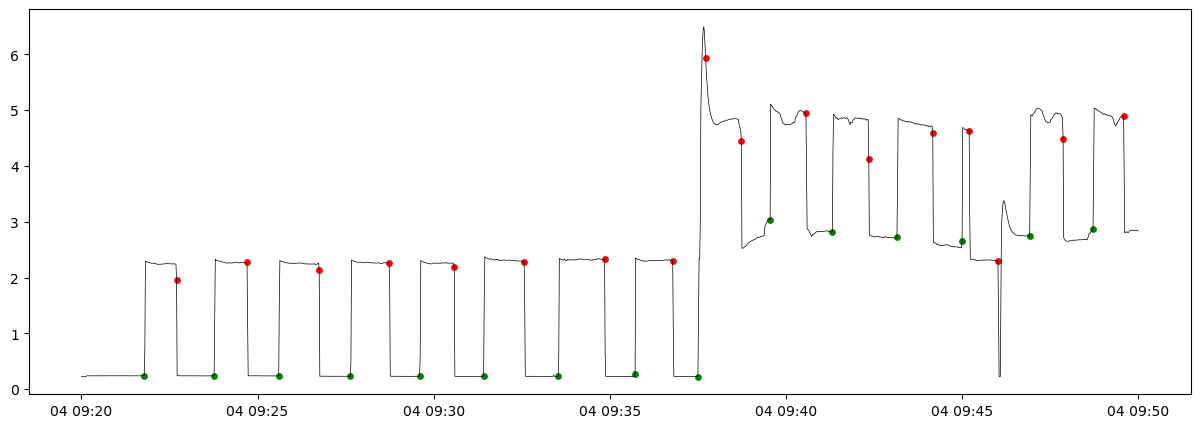

In [249]:
stdate='2021-01-04 09:20:00'
enddate='2021-01-04 09:50:00'
# stdate='2021-01-04 00:32:10'
# enddate='2021-01-04 08:15:00'
temp_data=sample_data[(sample_data['logged_time_local']>=pd.to_datetime(stdate)) & (sample_data['logged_time_local']<=pd.to_datetime(enddate))].set_index('logged_time_local')
temp_data['observable_event']=0
tuya=pivot_data[(pivot_data['event_time_utc']>=pd.to_datetime(stdate)) & (pivot_data['event_time_utc']<=pd.to_datetime(enddate))].set_index('event_time_utc')

# for i in temp_data[temp_data['event_type'].isin([1])].index:
#     if (temp_data.loc[i,'mains_power']>=0.10 and abs(temp_data.loc[i,'per_change']))>10:
#         temp_data.loc[i,'observable_event']=1
#     elif temp_data.loc[i,'mains_power']<0.10 and abs(temp_data.loc[i,'avg_diff'])>.015:
#         temp_data.loc[i,'observable_event']=1

temp_data['event_effect']=0
for i in range(len(temp_data)):
    if temp_data['event_type'].iloc[i]==1:
        after=0
        for j in range(i+1,min(i+1+mean_step*factor,len(temp_data)-1)):
            if (temp_data['event_type'].iloc[j] != 1):
                after=after +   temp_data['mains_power'].iloc[j]
            else:
                break
        after=after/(j-i)
        before=0
        for k in range(i-1,max(i-1-mean_step*factor,0),-1):
            if (temp_data['event_type'].iloc[k] != 1):
                before=before +   temp_data['mains_power'].iloc[k]
            else:
                break
        before=before/(i-k)
        temp_data['event_effect'].iloc[i]=after-before
    
temp_data.loc[temp_data['event_type']==1,'event_effect_original']=temp_data.loc[temp_data['event_type']==1,'after_mean_10']-temp_data.loc[temp_data['event_type']==1,'before_mean_10']
# temp_data.loc[temp_data['event_type']==1,'event_effect_peak']=temp_data.loc[temp_data['event_type']==1,'after_max_10']-temp_data.loc[temp_data['event_type']==1,'before_max_10']

temp_data.loc[(abs(temp_data['event_effect'])>.010),'observable_event']=1
temp_data.loc[(temp_data['avg_diff']<0) & (temp_data['observable_event']==1),'observable_event']=2

temp_data2=temp_data[temp_data['observable_event'].isin([1])]
temp_data3=temp_data[temp_data['observable_event'].isin([2])]
fig,ax=plt.subplots()
# ax2=ax.twinx()
matplotlib.style.use('default')
fig.set_size_inches(15,5)
tuya_data
ax.scatter(temp_data2.index,temp_data2.mains_power, color='green', s=15)
ax.scatter(temp_data3.index,temp_data3.mains_power,color='red', s=15)
ax.plot(temp_data.index,temp_data.mains_power,color='black', lw=.5)
# ax.set_ylim()
ax.legend

# (tuya.reset_index().pivot_table(index='event_time_utc',columns='device_name',values='cur_power')/1000).plot(ax=ax)

In [245]:
len(temp_data[temp_data['observable_event'].isin([2])][['event_effect']])

60

In [162]:
def classify_appliance(appliances,power):
    if appliances=='all':
        return device_map['appliance'].iloc[(device_map['mean_power_consumption']-power).abs().argsort()[:1]].values[0]
    else:
        if len(device_map.loc[device_map['appliance'].isin(appliances)])==0:
            return 0
        else:
            return device_map.loc[device_map['appliance'].isin(appliances),'appliance'].iloc[(device_map.loc[device_map['appliance'].isin(active_appliances.keys()), 'mean_power_consumption']-abs(power)).abs().argsort()[:1]].values[0]
    
def estimated_usage(std,endd,appliance):
    return device_map.loc[device_map['appliance']==appliance, 'mean_power_consumption']*(endd-std).seconds/3600


event_df=pd.DataFrame(columns=['start_date','end_date','running_avg','appliance','status','total_energy_consumed','start_time','end_time'])

stdate='2021-01-04 00:00:00'
enddate='2021-01-05 00:00:00'
ind=1
prev_running_avg=.088
high=0
medium=0
low=1
active_appliances={}
active_appliances['other']=stdate
for start,end in zip(pd.date_range(stdate,enddate, freq='30min')[:-1],pd.date_range(stdate,enddate, freq='30min')[1:]):
    event_df_temp=pd.DataFrame(columns=['start_date','end_date','running_avg','appliance','status','total_energy_consumed','start_time','end_time'])
    temp=temp_data[(temp_data.index<=end) & (temp_data.index>=start)]
    event_df_temp.loc[ind]=[start,end,prev_running_avg,'all','NA',temp['mains_power'].sum()/3600,None,None]
    
    for appliance in active_appliances.keys():
        ind=ind+1
        event_df_temp.loc[ind,'appliance']=appliance
        event_df_temp.loc[event_df_temp['appliance']==appliance,'start_time']=str(start)
    for i in range(len(temp)):
        if temp['observable_event'].iloc[i]==1:
            
            appliance=classify_appliance('all',abs(temp['event_effect'].iloc[i]))
            if appliance in event_df_temp['appliance'].unique():
                if appliance in active_appliances.keys():
                    continue
                else:
                    active_appliances[appliance]=str(temp.index[i])
                    event_df_temp.loc[event_df_temp['appliance']==appliance,'status']='active'
                    event_df_temp.loc[event_df_temp['appliance']==appliance,'start_time']=str(event_df_temp.loc[event_df_temp['appliance']==appliance,'start_time'].values[0])+' '+str(temp.index[i])
            else:
                ind=ind+1
                event_df_temp.loc[ind,'start_time']=str(temp.index[i])
                event_df_temp.loc[ind,'appliance']=appliance
                event_df_temp.loc[ind,'status']='active'
    #             category=device_map.loc[device_map['appliance']==appliance,'device_category'].values[0]
    #             event_df_temp.loc[ind,category]=event_df_temp.loc[ind-1,category]+1
                active_appliances[appliance]=str(temp.index[i])


        elif temp['observable_event'].iloc[i]==2:
            appliance=classify_appliance(active_appliances.keys(),abs(temp['event_effect'].iloc[i]))
            if appliance==0:
                continue
            if  len(event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time'].dropna())==0:
                event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time']=str(temp.index[i])
            else:
                event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time']=str(event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time'].values[0])+','+str(temp.index[i])
#                 print(str(event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time']))
            event_df_temp.loc[event_df_temp['appliance']==appliance,'total_energy_consumed']=event_df_temp.loc[event_df_temp['appliance']==appliance,'total_energy_consumed'].fillna(0).values[0]+estimated_usage(max(start,pd.to_datetime(active_appliances[appliance])),temp.index[i],appliance).values[0]
            event_df_temp.loc[event_df_temp['appliance']==appliance,'status']='off'
            del active_appliances[appliance]
        else:
            continue
            
    for appliance in active_appliances.keys():
        if appliance=='other':
            continue
        if len(event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time'].dropna())==0:
            event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time']=str(temp.index[i])
            event_df_temp.loc[event_df_temp['appliance']==appliance,'total_energy_consumed']=event_df_temp.loc[event_df_temp['appliance']==appliance,'total_energy_consumed'].fillna(0).values[0]+estimated_usage(max(start,pd.to_datetime(active_appliances[appliance])),end,appliance).values[0]
        else:
            event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time']=str(event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time'].values[0])+','+str(temp.index[i])
            event_df_temp.loc[event_df_temp['appliance']==appliance,'total_energy_consumed']=event_df_temp.loc[event_df_temp['appliance']==appliance,'total_energy_consumed'].fillna(0).values[0]+estimated_usage(max(start,pd.to_datetime(active_appliances[appliance])),end,appliance).values[0]
    if len(active_appliances.keys())==1:
        prev_running_avg=temp['mains_power'][-10:].mean()
        event_df_temp.loc[event_df_temp['appliance']=='other','total_energy_consumed']=prev_running_avg*(end-start).seconds/3600
    else:
        event_df_temp.loc[event_df_temp['appliance']=='other','total_energy_consumed']=prev_running_avg*(end-start).seconds/3600
    
    event_df_temp['start_date']=start
    event_df_temp['end_date']=end
    
    event_df=event_df.append(event_df_temp)

device_map1=device_map[['appliance','device_id']].set_index('appliance').to_dict()['device_id']
device_map2=device_map[['appliance','room']].set_index('appliance').to_dict()['room']
device_map3=device_map[['appliance','device_category']].set_index('appliance').to_dict()['device_category']
event_df['device_id']=event_df['appliance'].map(device_map1)
event_df['room']=event_df['appliance'].map(device_map2)

event_df['device_category']=event_df['appliance'].map(device_map3)
event_df.loc[event_df['appliance']=='other','device_category']=event_df.loc[event_df['appliance']!='all','device_category'].fillna('other')

In [12]:
event_df.to_csv('output_v6.csv')

In [165]:
event_df.appliance.unique()

array(['all', 'other', 'Fridge', 'Exhaust Fan1', 'Unknown Device',
       'Microwave', 'Washing Machine'], dtype=object)

In [43]:
# df=pd.read_csv('test_outpuut_main.csv')
df=event_df

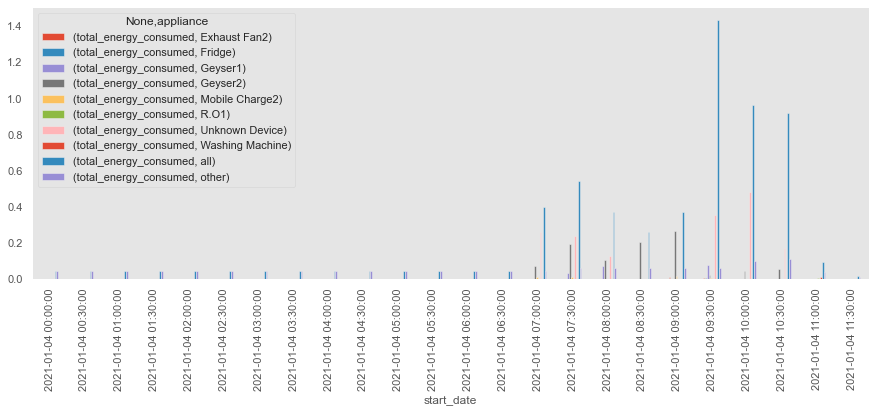

In [47]:
df['start_date']=pd.to_datetime(df['start_date']).ffill()
df['end_date']=pd.to_datetime(df['end_date']).ffill()
df_pivot=df.pivot_table(index=['start_date','appliance'], values='total_energy_consumed', aggfunc=np.sum)
# df_pivot.unstack().plot(kind='bar')
matplotlib.style.use('fast')
fig,ax=plt.subplots()
# ax2=ax.twinx()
fig.set_size_inches(15,5)
df_pivot.unstack().plot(kind='bar',ax=ax)
ax.grid('')

# ax.legend('')
# tuya_data
# ax.scatter(temp_data2.index,temp_data2.mains_power, color='green', s=15)
# ax.scatter(temp_data3.index,temp_data3.mains_power,color='red', s=15)
# ax.plot(temp_data.index,temp_data.mains_power,color='black', lw=.5)

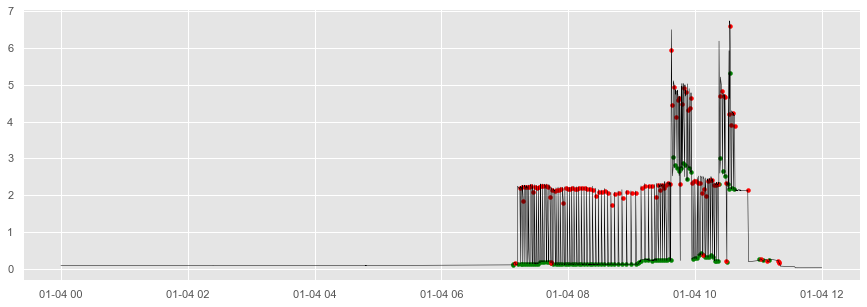

In [46]:
temp_data2=temp_data[temp_data['observable_event'].isin([1])]
temp_data3=temp_data[temp_data['observable_event'].isin([2])]
fig,ax=plt.subplots()
# ax2=ax.twinx()
fig.set_size_inches(15,5)
tuya_data
ax.scatter(temp_data2.index,temp_data2.mains_power, color='green', s=15)
ax.scatter(temp_data3.index,temp_data3.mains_power,color='red', s=15)
ax.plot(temp_data.index,temp_data.mains_power,color='black', lw=.5)

In [1636]:
event_df=pd.DataFrame(columns=['start_date','end_date','running_avg','appliance','status','total_energy_consumed','start_time','end_time'])
event_df_temp=event_df

ind=1
prev_running_avg=.025
high=0
medium=0
low=1
active_appliances={}
active_appliances['other']=stdate
event_df_temp['end_time'] = ''
event_df_temp['start_time'] = ''

start=pd.to_datetime('2021-01-04 06:00:00')
end=pd.to_datetime('2021-01-04 09:30:00')

temp=temp_data[(temp_data.index<=end) & (temp_data.index>=start)]
event_df_temp.loc[ind]=[start,end,prev_running_avg,'all','NA',temp['mains_power'].sum()/3600,None,None]

for i in range(len(temp)):
    if temp['observable_event'].iloc[i]==1:
        ind=ind+1
        appliance=classify_appliance('all',abs(temp['event_effect'].iloc[i]))
        if appliance in event_df_temp['appliance'].unique():
            if appliance in active_appliances.keys():
                continue
            else:
                active_appliances[appliance]=temp.index[i]
                event_df_temp.loc[event_df_temp['appliance']==appliance,'status']='active'
                event_df_temp.loc[event_df_temp['appliance']==appliance,'start_time'].iloc[0].append(temp.index[i])
        else:
            event_df_temp.loc[ind,'start_time']=[[temp.index[i]]]
            event_df_temp.loc[ind,'appliance']=appliance
            event_df_temp.loc[ind,'status']='active'
#             category=device_map.loc[device_map['appliance']==appliance,'device_category'].values[0]
#             event_df_temp.loc[ind,category]=event_df_temp.loc[ind-1,category]+1
            active_appliances[appliance]=temp.index[i]
            
        
    elif temp['observable_event'].iloc[i]==2:
        appliance=classify_appliance(active_appliances.keys(),abs(temp['event_effect'].iloc[i]))
        if appliance==0:
            continue
        if  len(event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time'].dropna())==0:
            event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time']=str(temp.index[i])
        else:
            event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time']=str(event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time'].values[0])+','+str(temp.index[i])
#             print(str(event_df_temp.loc[event_df_temp['appliance']==appliance,'end_time']))
        event_df_temp.loc[event_df_temp['appliance']==appliance,'total_energy_consumed']=event_df_temp.loc[event_df_temp['appliance']==appliance,'total_energy_consumed'].fillna(0).values[0]+estimated_usage(max(start,active_appliances[appliance]),temp.index[i],appliance).values[0]
        event_df_temp.loc[event_df_temp['appliance']==appliance,'status']='off'
        del active_appliances[appliance]
    else:
        continue

    

In [1679]:
appliance

'other'

In [1552]:
event_df.to_csv(r'test_output.csv')

PermissionError: [Errno 13] Permission denied: 'test_output.csv'

In [1340]:
pivot_data[pivot_data['event_time_utc']>=pd.to_datetime('2021-01-04').switch_1

SyntaxError: unexpected EOF while parsing (<ipython-input-1340-5bbf21521189>, line 1)

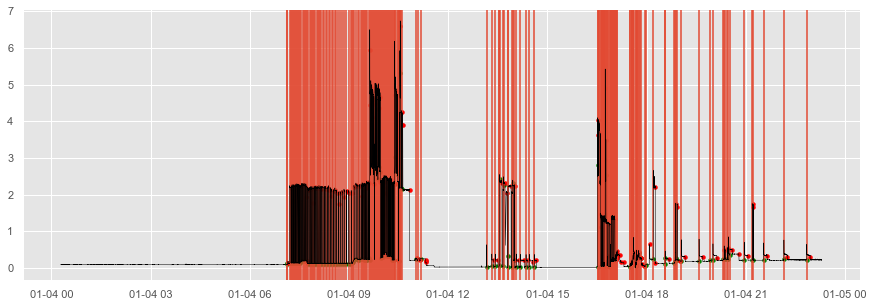

In [1269]:
stdate='2021-01-04 00:17:10'
enddate='2021-01-04 23:17:50'

sample=temp_data.reset_index()[(temp_data.reset_index()['logged_time_local']>=pd.to_datetime(stdate)) & (temp_data.reset_index()['logged_time_local']<=pd.to_datetime(enddate))].set_index('logged_time_local')
temp_data2=sample[sample['observable_event'].isin([1])]
temp_data3=sample[sample['observable_event'].isin([2])]
fig,ax=plt.subplots()
# ax2=ax.twinx()
fig.set_size_inches(15,5)
tuya_data
ax.scatter(temp_data2.index,temp_data2.mains_power, color='green', s=15)
ax.scatter(temp_data3.index,temp_data3.mains_power,color='red', s=15)
for i in range(len(event_df.dropna(subset=['start_date']))):
    ax.axvline(event_df.dropna(subset=['start_date']).start_date.iloc[i], colour=)
ax.plot(temp_data.index,temp_data.mains_power,color='black', lw=.5)

In [1271]:
sig=pd.read_csv('signatures.csv')
sig['logged_time_local']=pd.to_datetime(sig['logged_time_local'])
sig=sig.set_index('logged_time_local').sort_index()
signatures=pd.DataFrame(sig['mains_power'])
signatures['AC']=0
signatures['Geyser']=0
signatures['AC_Subtracted']=0
signatures['Geyser_Subtracted']=0
signatures['Event_AC']=0
signatures['Event_Geyser']=0

for device in ['AC','Geyser']:
    event=1
    for start,end in zip(sig.loc[sig[device]==1].index,sig.loc[sig[device]==2].index):
        signatures.loc[(signatures.index>=start) & (signatures.index<=end),device]=signatures.loc[(sig.index>=start) & (sig.index<=end),'mains_power']
        signatures.loc[(signatures.index>=start) & (signatures.index<=end),'Event_'+device]=event
        event=event+1
        signatures.loc[(signatures.index>=start) & (signatures.index<=end),device+'_Subtracted']=signatures.loc[(signatures.index>=start) & (signatures.index<=end),device]-sig.loc[(sig.index>=(start-datetime.timedelta(seconds=10))) & (sig.index<=start),'mains_power'].mean()
        
signatures['AC_Switch']=sig['AC']
signatures['Geyser_Switch']=sig['Geyser']
signatures.to_csv('extracted_signatures.csv')
            


KeyError: 'logged_time_local'

In [808]:
train=pd.read_csv('train_sample.csv')
train['logged_time_local']=pd.to_datetime(train['logged_time_local'])

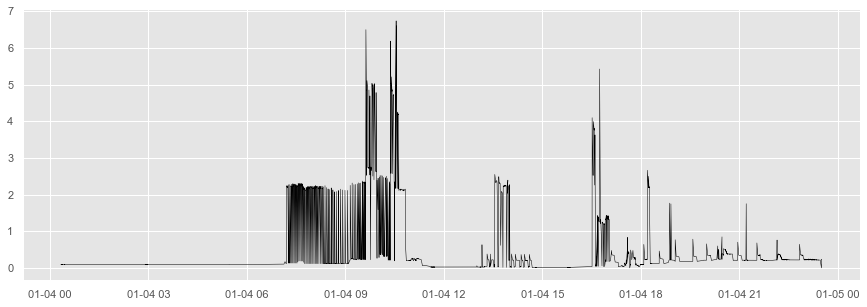

In [133]:
stdate='2021-01-04 00:20:10'
enddate='2021-01-04 23:30:50'
# stdate='2021-01-04 17:12:10'
# enddate='2021-01-04 17:15:00'
temp_data=sample_data[(sample_data['logged_time_local']>=pd.to_datetime(stdate)) & (sample_data['logged_time_local']<=pd.to_datetime(enddate))].set_index('logged_time_local')
temp_data['observable_event']=0

# for i in temp_data[temp_data['event_type'].isin([1])].index:
#     if (temp_data.loc[i,'mains_power']>=0.10 and abs(temp_data.loc[i,'per_change']))>10:
#         temp_data.loc[i,'observable_event']=1
#     elif temp_data.loc[i,'mains_power']<0.10 and abs(temp_data.loc[i,'avg_diff'])>.015:
#         temp_data.loc[i,'observable_event']=1

temp_data['event_effect']=0
temp_data.loc[temp_data['event_type']==1,'+']=temp_data.loc[temp_data['event_type']==1,'after_mean_10']-temp_data.loc[temp_data['event_type']==1,'before_mean_10']
temp_data.loc[abs(temp_data['event_effect'])>.010,'observable_event']=1
temp_data.loc[(temp_data['avg_diff']<0) & (temp_data['observable_event']==1),'observable_event']=2

temp_data2=temp_data[temp_data['observable_event'].isin([1])]
temp_data3=temp_data[temp_data['observable_event'].isin([2])]
fig,ax=plt.subplots()
# ax2=ax.twinx()
fig.set_size_inches(15,5)
tuya_data
ax.scatter(temp_data2.index,temp_data2.mains_power, color='green', s=15)
ax.scatter(temp_data3.index,temp_data3.mains_power,color='red', s=15)
ax.plot(temp_data.index,temp_data.mains_power,color='black', lw=.5)


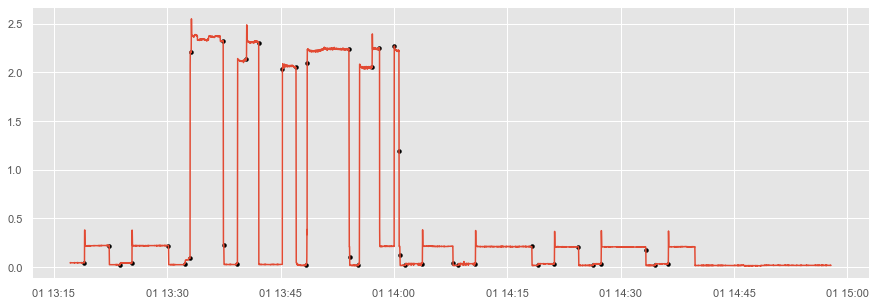

In [1130]:
stdate='2021-04-01 13:17:10'
enddate='2021-04-01 14:57:50'
temp_data=train[(train['logged_time_local']>=pd.to_datetime(stdate)) & (train['logged_time_local']<=pd.to_datetime(enddate))].set_index('logged_time_local')
temp_data2=temp_data[temp_data['activity'].isin([1,2])]
fig,ax=plt.subplots()
# ax2=ax.twinx()
fig.set_size_inches(15,5)
tuya_data
ax.scatter(temp_data2.index,temp_data2.mains_power, color='black', s=15)
# ax.scatter(temp_data2.index,temp_data2.event_effect,color='green', s=15)
ax.plot(temp_data.index,temp_data.mains_power)

In [815]:
train[(train['logged_time_local']>=pd.to_datetime(stdate))]

,logged_time_local,mains_power,before_mean,before_max,after_mean,after_max,per_change,time_spent,avg_diff,events,event_type,event_effect,activity
0,2021-04-01 11:40:00,0.025,0.0244,0.025,0.0248,0.025,0.000000,0,0.0004,0,0,0.000,0.0
1,2021-04-01 11:40:01,0.025,0.0248,0.025,0.0248,0.025,1.612903,0,0.0000,0,0,0.000,0.0
2,2021-04-01 11:40:02,0.025,0.0248,0.025,0.0248,0.025,0.000000,0,0.0000,0,0,0.000,0.0
3,2021-04-01 11:40:03,0.025,0.0248,0.025,0.0252,0.027,1.587302,0,0.0004,0,0,0.000,0.0
4,2021-04-01 11:40:04,0.024,0.0248,0.025,0.0254,0.027,2.362205,0,0.0006,0,0,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,2021-04-01 16:59:56,0.269,0.1970,0.269,0.2480,0.269,27.822581,0,0.0510,1,2,0.000,0.0
19196,2021-04-01 16:59:57,0.266,0.2146,0.269,0.2638,0.269,25.322214,0,0.0492,1,2,0.000,0.0
19197,2021-04-01 16:59:58,0.262,0.2310,0.269,0.2622,0.266,18.154081,0,0.0312,1,2,0.000,0.0
19198,2021-04-01 16:59:59,0.263,0.2480,0.269,0.2610,0.263,11.494253,0,0.0130,1,2,0.000,0.0


In [ ]:
# count=1
# h=0
# m=0
# l=0
# for i in temp_data.index:
#     if temp_data.loc[i,'observable_event']<1:
#         continue
#     elif temp_data.loc[i,'observable_event']==1:
#         event_df.loc[count,'mains_power_start']= temp_data.loc[i,'mains_power']
#         event_df.loc[count,'start_date']=i
#         event_df=event_df.fillna(0)
#         if temp_data.loc[i,'event_effect']<.1:
#             l=l+1
#             event_df.loc[count,'low']=l
#             event_df.loc[count,'event_type']='low'
#         if (temp_data.loc[i,'event_effect']>=.1) & (temp_data.loc[i,'event_effect']<1):
#             m=m+1
#             event_df.loc[count,'medium']=m
#             event_df.loc[count,'event_type']='medium'
#         if temp_data.loc[i,'event_effect']>=1:
#             h=h+1
#             event_df.loc[count,'high']=h
#             event_df.loc[count,'event_type']='high'
#         event_df.loc[count,'event_effect']=temp_data.loc[i,'event_effect']
#         count=count+1
#         event_df.loc[count,'status']='active'
#     elif temp_data.loc[i,'observable_event']==2:
#         effect_val=abs(temp_data.loc[i,'event_effect'])
#         if effect_val<.1:
#             effect='low'
#             l=max(0,l-1)
#         elif (effect_val>=.1) & (effect_val<1):
#             effect='medium'
#             m=max(0,m-1)
#         else:
#             h=max(0,h-1)
#             effect='high'
        
#         for ind in event_df.loc[(event_df['event_type']==effect) & (event_df['status']=='active')].iloc[(event_df.loc[(event_df['event_type']==effect) & (event_df['status']=='active')]['event_effect']-effect_val).abs().argsort()[:1]].index:
#             if event_df.loc[ind,'end_date']==0:
#                 event_df.loc[ind,'end_date']=i
#                 break
#             else:
#                 continue
        
#         event_df.loc[ind,'end_class']=effect
#         event_df.loc[ind, 'status']= 'switched_off'
#         event_df.loc[(event_df.index>ind), effect]=max(0,event_df.loc[ind, effect]-1)


In [211]:
len(temp_data)

1201